In [1]:
# Basic
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import pinv2
from tqdm import tqdm
import pandas as pd
import itertools

# For Dataset
from collections import deque, namedtuple
import random

# For solvers
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp
from casadi import *
import casadi

# For estimators
from torch import nn
import torch
import torch.nn.functional as F

In [2]:
from utils.system import AAC
from utils.controller import *
from utils.dataset import *
from utils.estimator import *
from utils.normalizer import *
from utils.functions import *


In [3]:
dt = 0.01
simTime = 10

# Real parameters
v_lead = 20
v_des = 24
m  = 1650.0
g = 9.81

# 
f0 = 0.1
f1 = 5
f2 = 0.25


c_a = 0.3
c_d = 0.3
Th = 1.8

# Nominal parameters
f0_nom = 10*f0
f1_nom = 10*f1
f2_nom = 10*f2

p_slack = 2e-2
clf_rate = 5
cbf_rate = 5.

# Initial state
p0 = 0
v0 = 20
z0 = 40

x = [p0, v0 ,z0]




In [4]:
def c2l(d):
    if type(d) == float or type(d) == int or type(d) == np.float64:
        return [d]
    if type(d) == list:
        return d
    if type(d) == np.ndarray:
        return d.tolist()
    

In [6]:
# System
aac = AAC(m, c_d, f0, f1, f2, v_lead)
derivator = Derivator(dt)

# Controller
cont = LCBF(0.8*m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_lead, v_des, Th, clf_rate, cbf_rate, p_slack)

# Estimator
input_size = 3 
hidden_size = 100
output_size = 1


learned_ratio = 1.5
time_th = learned_ratio* hidden_size


weights = 0.2

# Normalizers



# PID control reference
x_dim = 3
u_dim = 1

kp = np.array([[0, 1.0e3, 0]])
kd = np.array([[0, 0.1, 0]])
ki = np.array([[0, 1.0e3, 0]])

pid = PID(x_dim, u_dim, kp, kd, ki, dt)



####
# Filename
# OSELM: lr_pre + lr_post + z0 + v0 + func
lr_pres =  [1e-2, 1e-3]
lr_posts =  [1e-2]
z0s = [30, 34, 38]
v0s = [20]
funcs = [sin, square]

data_dir = 'data/oselm'

cases = len(list(itertools.product(lr_pres, lr_posts, z0s, v0s, funcs)))
pbar = tqdm(total=cases*simTime/dt)

for lr_pre, lr_post, z0, v0, func in itertools.product(lr_pres, lr_posts, z0s, v0s, funcs):
    x = [0, v0, z0]
    fn = "{}_{}_{}_{}_{}.csv".format(lr_pre, lr_post, z0, v0, func.__name__)
    
    # Database
    column_names = ['p', 'v', 'z', 'u','u_ref','V','h','dhe_real','dhe','slack']
    df = pd.DataFrame(columns=column_names,dtype=object)

    # save file .csv
    path = os.path.join(data_dir, fn)
    df.to_csv(path, index=False)
    
    # Estimator
    estimator = ELMs(input_size, hidden_size, output_size, time_th, dt, lr_pre, lr_post)
    
    # Normalizer
    norm_x = WelfordNormalizerOne((3,))
    norm_u = WelfordNormalizerOne((1,))
    norm_dhe = WelfordNormalizerOne((1,))

    normalizer = {'x':norm_x, 'u':norm_u, 'dhe':norm_dhe}
    
    ## Dataset
    d = ELMDataset(('x', 'k', 'dhe_real'), time_th )

    for t in np.arange(0, simTime, dt): #simTime
        pbar.update(1)
        # Get reference control
        e = np.array([[0], [v_des], [0]]) - np.expand_dims(x, axis = 1)
        u_ref = pid.update(e)
        u_ref = u_ref[0,0]
       
        unct = func(t)
        aac.v_lead = v_lead + unct  # lead_vehicle

        # Control Input
        k, slack_sol, V, dV, h, dh, dhe, dS = cont.compute_controller(x, u_ref, estimator, weights, t, normalizer) 
       
        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)

        dh_real = derivator.update(h)
        dhe_real = dh_real - dh

        
        dhe_real_norm = normalizer['dhe'].update(dhe_real)
        x_norm = normalizer['x'].update(x)
        k_norm = normalizer['u'].update(k)
        
        row = c2l(x) + c2l(k) + c2l(u_ref) + c2l(V) + c2l(h) + c2l(dhe_real) + c2l(dhe) + c2l(slack_sol)
        df_row = pd.DataFrame(dict(zip(column_names, row)), index = [0])
        
        df.append(df_row, sort = False).to_csv(path, index=False, mode = 'a', header=False)

        x = x_n
        
        d.update(t, x_norm, k_norm[0].item(), dhe_real_norm)
        
        estimator.train(t, d)
                    
pbar.close()
    
        
        

 


  0%|          | 0/12000.0 [00:00<?, ?it/s]
  0%|          | 5/12000.0 [00:00<04:03, 49.27it/s]
  0%|          | 10/12000.0 [00:00<04:10, 47.90it/s]
  0%|          | 15/12000.0 [00:00<04:16, 46.68it/s]
  0%|          | 20/12000.0 [00:00<04:58, 40.11it/s]
  0%|          | 25/12000.0 [00:00<05:14, 38.06it/s]
  0%|          | 29/12000.0 [00:00<05:23, 37.03it/s]
  0%|          | 33/12000.0 [00:00<05:37, 35.41it/s]
  0%|          | 37/12000.0 [00:00<05:32, 35.93it/s]
  0%|          | 41/12000.0 [00:01<05:32, 35.98it/s]
  0%|          | 45/12000.0 [00:01<05:56, 33.58it/s]
  0%|          | 49/12000.0 [00:01<05:45, 34.59it/s]
  0%|          | 53/12000.0 [00:01<05:55, 33.65it/s]
  1%|          | 63/12000.0 [00:01<03:54, 50.80it/s]
  1%|          | 72/12000.0 [00:01<03:15, 60.94it/s]
  1%|          | 81/12000.0 [00:01<02:55, 67.97it/s]
  1%|          | 91/12000.0 [00:01<02:37, 75.75it/s]
  1%|          | 102/12000.0 [00:01<02:19, 85.43it/s]
  1%|          | 113/12000.0 [00:02<02:10, 90.75it/s]


  3%|▎         | 303/12000.0 [00:36<45:26,  4.29it/s]
  3%|▎         | 304/12000.0 [00:36<45:04,  4.32it/s]
  3%|▎         | 305/12000.0 [00:37<44:54,  4.34it/s]
  3%|▎         | 306/12000.0 [00:37<45:34,  4.28it/s]
  3%|▎         | 307/12000.0 [00:37<45:55,  4.24it/s]
  3%|▎         | 308/12000.0 [00:37<46:41,  4.17it/s]
  3%|▎         | 309/12000.0 [00:38<46:48,  4.16it/s]
  3%|▎         | 310/12000.0 [00:38<46:20,  4.20it/s]
  3%|▎         | 311/12000.0 [00:38<45:23,  4.29it/s]
  3%|▎         | 312/12000.0 [00:38<46:08,  4.22it/s]
  3%|▎         | 313/12000.0 [00:39<46:20,  4.20it/s]
  3%|▎         | 314/12000.0 [00:39<46:41,  4.17it/s]
  3%|▎         | 315/12000.0 [00:39<47:45,  4.08it/s]
  3%|▎         | 316/12000.0 [00:39<47:46,  4.08it/s]
  3%|▎         | 317/12000.0 [00:40<47:20,  4.11it/s]
  3%|▎         | 318/12000.0 [00:40<47:19,  4.11it/s]
  3%|▎         | 319/12000.0 [00:40<47:58,  4.06it/s]
  3%|▎         | 320/12000.0 [00:40<48:41,  4.00it/s]
  3%|▎         | 321/12000.0

  4%|▎         | 445/12000.0 [01:18<1:06:55,  2.88it/s]
  4%|▎         | 446/12000.0 [01:18<1:06:40,  2.89it/s]
  4%|▎         | 447/12000.0 [01:18<1:06:09,  2.91it/s]
  4%|▎         | 448/12000.0 [01:19<1:06:01,  2.92it/s]
  4%|▎         | 449/12000.0 [01:19<1:08:13,  2.82it/s]
  4%|▍         | 450/12000.0 [01:20<1:09:24,  2.77it/s]
  4%|▍         | 451/12000.0 [01:20<1:07:38,  2.85it/s]
  4%|▍         | 452/12000.0 [01:20<1:09:27,  2.77it/s]
  4%|▍         | 453/12000.0 [01:21<1:09:32,  2.77it/s]
  4%|▍         | 454/12000.0 [01:21<1:09:34,  2.77it/s]
  4%|▍         | 455/12000.0 [01:21<1:12:21,  2.66it/s]
  4%|▍         | 456/12000.0 [01:22<1:19:01,  2.43it/s]
  4%|▍         | 457/12000.0 [01:22<1:18:15,  2.46it/s]
  4%|▍         | 458/12000.0 [01:23<1:16:01,  2.53it/s]
  4%|▍         | 459/12000.0 [01:23<1:13:40,  2.61it/s]
  4%|▍         | 460/12000.0 [01:23<1:13:14,  2.63it/s]
  4%|▍         | 461/12000.0 [01:24<1:14:20,  2.59it/s]
  4%|▍         | 462/12000.0 [01:24<1:13:02,  2.

KeyboardInterrupt: 

243

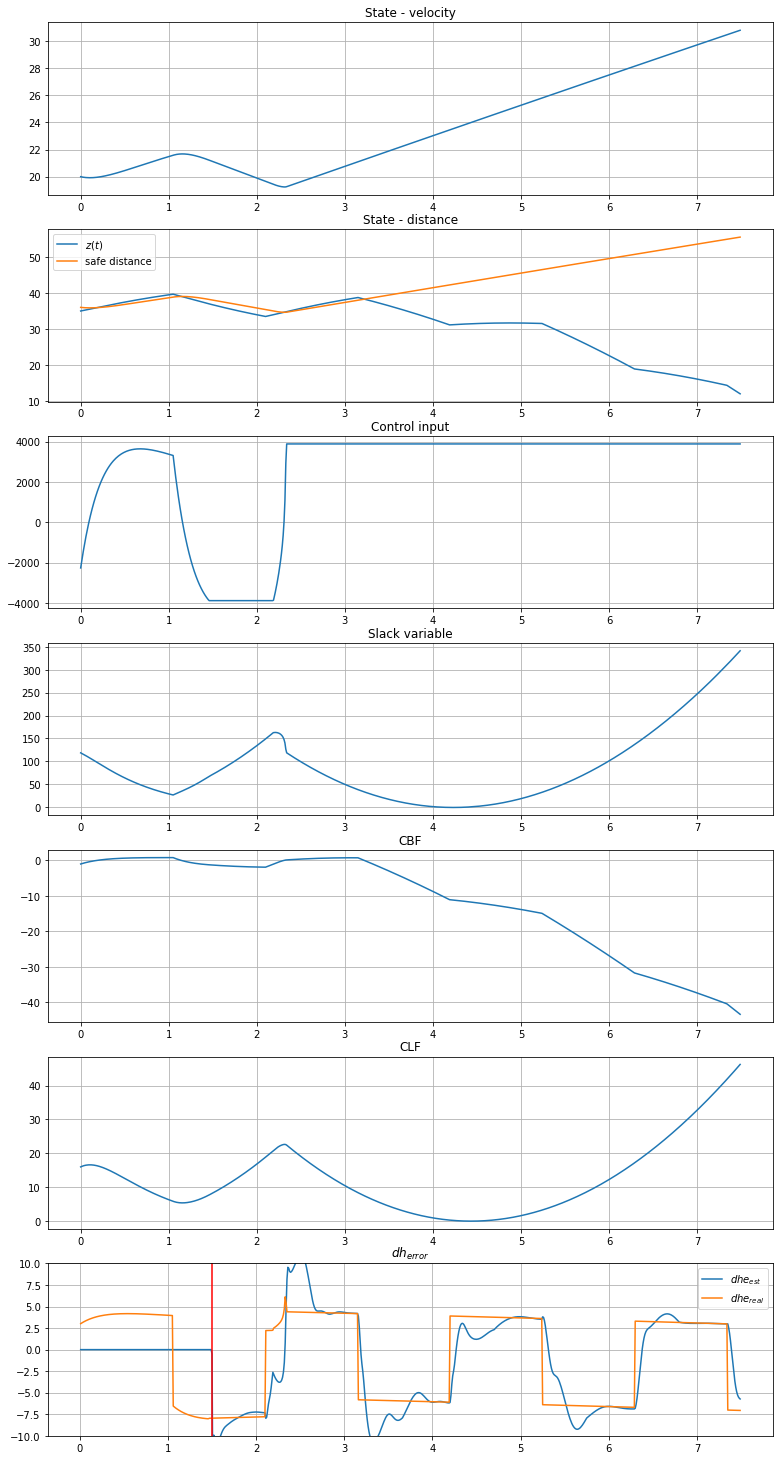

In [6]:

i = 0

f,ax = plt.subplots(7,1,figsize = (13,26))
t_lns = np.arange(0, simTime, dt)

ax[0].plot(t_lns, np.array(xs_lst)[i,:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')

ax[1].plot(t_lns,  np.array(xs_lst)[i,:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')


ax[1].plot(t_lns, Th*np.array(xs_lst)[i,:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)
ax[1].legend(['$z(t)$','safe distance'])

ax[2].plot(t_lns,  np.array(us_lst)[i,:])
ax[2].grid(True)
ax[2].set_title('Control input')


ax[3].plot(t_lns, np.array(slacks_lst)[i,:])
ax[3].grid(True)
ax[3].set_title('Slack variable')


ax[4].plot(t_lns, np.array(hs_lst)[i,:])
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, np.array(Vs_lst)[i,:])
ax[5].grid(True)
ax[5].set_title('CLF')

ax[6].plot(t_lns[1:], np.array(dhes_lst)[i, 1:])
ax[6].plot(t_lns[1:], np.array(dhe_reals_lst)[i,1:])
ax[6].grid(True)
ax[6].set_title('$dh_{error}$')
ax[6].axvline(x = time_th *dt, color = 'red')

ax[6].set_ylim([-10,10])
ax[6].legend(['$dhe_{est}$','$dhe_{real}$'])

In [ ]:
f,ax = plt.subplots(7,1,figsize = (13,26))
t_lns = np.arange(0, simTime, dt)

for i in range(laps):
    ax[0].plot(t_lns, np.array(xs_lst)[i,:,1])
    ax[0].grid(True)
    ax[0].set_title('State - velocity')
    
    ax[1].plot(t_lns,  np.array(xs_lst)[i,:,2])
    ax[1].grid(True)
    ax[1].set_title('State - distance')
    
    #ax[1].plot(t_lns, Th*np.array(xs)[:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

    ax[2].plot(t_lns,  np.array(us_lst)[i,:])
    ax[2].grid(True)
    ax[2].set_title('Control input')
    

    ax[3].plot(t_lns, np.array(slacks_lst)[i,:])
    ax[3].grid(True)
    ax[3].set_title('Slack variable')
    

    ax[4].plot(t_lns, np.array(hs_lst)[i,:])
    ax[4].grid(True)
    ax[4].set_title('CBF')

    ax[5].plot(t_lns, np.array(Vs_lst)[i,:])
    ax[5].grid(True)
    ax[5].set_title('CLF')

    #ax[6].plot(t_lns[1:], np.array(dhes_lst)[i, 1:])
    ax[6].plot(t_lns[1:], np.array(dhe_reals_lst)[i,1:])
    ax[6].grid(True)
    ax[6].set_title('$dh_{error}$')
    

    #ax[6].set_ylim([-10,10])
    ax[6].legend(dlst)


In [ ]:
a = deque([1,2,3,4,5])

In [ ]:
b = deque(maxlen=3)

In [ ]:
list(a)

In [ ]:
b.append(list(a))

In [ ]:
b